In [96]:
from pathlib import Path
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Loading data in

In [200]:
def get_results(path="/mnt/c/github/explainabloomity/results"):
    models = ("opt-13b", "bloom-7b1")
    prune_methods=(
        "balanced",
        "balanced_mask",
        "imbalanced",
        "imbalanced_mask",
        "imbalanced_correct",
        "imbalanced_amazon",
        "imbalanced_correct_mask",
        "random_mask",
    )
    metrics=(
        "cosine_cosine",
        "euclidean_euclidean",
        "cosine_random",
        "euclidean_random",
        "random_random",
    )
    prunetasks=(
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
        "random"
    )
    prune_percents=(
        "0",
        "0.1",
        "0.2",
        "0.3",
        "0.4",
        "0.25",
        "0.5",
        "0.75",
    )
    tasks=(
        "paws_en",
        "hellaswag",
        "arc_easy",
        "blimp_ellipsis_n_bar_1",
        "blimp_irregular_plural_subject_verb_agreement_1",
        )
    rows = []
    for model in models:
        for prune_method in prune_methods:
            for prune_task in prunetasks:
                for prune_metric in metrics:
                    for task in tasks:
                        for prune_percent in prune_percents:
                            # Default path format
                            path_model = Path("./results") / task / model / prune_method / prune_task / prune_metric / prune_percent / "results.json"
                            if path_model.exists():
                                with open(path_model, "r", encoding='utf-8') as f:
                                    data = json.load(f)
                                    norm_accuracy = 1 - data["results"][task]["acc,none"] if task == "paws_en" else data["results"][task]["acc,none"]
                                    row = {
                                        "model": model, 
                                        "prune_method": prune_method, 
                                        "prune_task": prune_task, 
                                        "metric": prune_metric, 
                                        "percent": float(prune_percent), 
                                        "task": task, 
                                        "norm_accuracy": norm_accuracy
                                    }
                                    rows.append(row)
                                # Add base model results
                                base_model = model + "_base"
                                path_model_base = Path("./results") / task / base_model / "results.json"
                                if path_model_base.exists():
                                    with open(path_model_base, "r") as f:
                                        data = json.load(f)
                                        norm_accuracy = 1 - data["results"][task]["acc,none"] if task == "paws_en" else data["results"][task]["acc,none"]
                                        row = {
                                            "model": model, 
                                            "prune_method": prune_method, 
                                            "prune_task": prune_task, 
                                            "metric": prune_metric, 
                                            "percent": 0.0, 
                                            "task": task, 
                                            "norm_accuracy": norm_accuracy
                                        }
                                        rows.append(row)

    df = pd.DataFrame(rows)
    return df

def load_amazon_results(directory='results/opt-13b_amazon'):
    rows =[]
    # Directory names are like '0shot_arc_easy', '0shot_hellaswag', etc.
    for dir_name in os.listdir(directory):
        dir_path = os.path.join(directory, dir_name)
        if os.path.isdir(dir_path):
            # File names are like '0shot_25percent', '0shot_50percent', etc.
            for file_name in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file_name)
                try:
                    with open(file_path, 'r') as file:
                        data = json.load(file)
                        # Extract pruning percentage from file name
                        pruning_percent = file_name.split('_')[1].replace('percent', '')
                        # Store data based on dir_name and pruning percent
                        for dataset, metrics in data['results'].items():
                            if 'acc' in metrics:
                                task = 'lambada_openai' if dataset == 'lambada' else dataset
                                norm_accuracy = 1 - metrics['acc'] if dataset == "paws_en" else metrics['acc']
                                row = {
                                    "model": 'opt-13b', 
                                    'prune_method': 'amazon', 
                                    'prune_task': dir_name, 
                                    'metric': 'amazon', 
                                    'percent': float(pruning_percent)/100, 
                                    'task': task, 
                                    'norm_accuracy': norm_accuracy}
                                rows.append(row)

                except Exception as e:
                    print(f'Error loading {file_path}: {e}')

    df = pd.DataFrame(rows)
    return df

df = get_results()
df2 = load_amazon_results()

# Combine the two dataframes
df_final = pd.concat([df, df2])

In [201]:
td = {'imbalanced_amazon': 'imbalanced mask LLMI', 'balanced_mask': 'balanced mask pruning', 'random_mask': 'random pruning', 'imbalanced_correct_mask': 'imbalanced mask pruning', 'imbalanced_correct': 'imbalanced duplicate pruning', 'amazon': 'importance score pruning', 'balanced': 'balanced duplicate pruning'}

## Plotting BLOOM results for imbalanced duplicate, masked and random

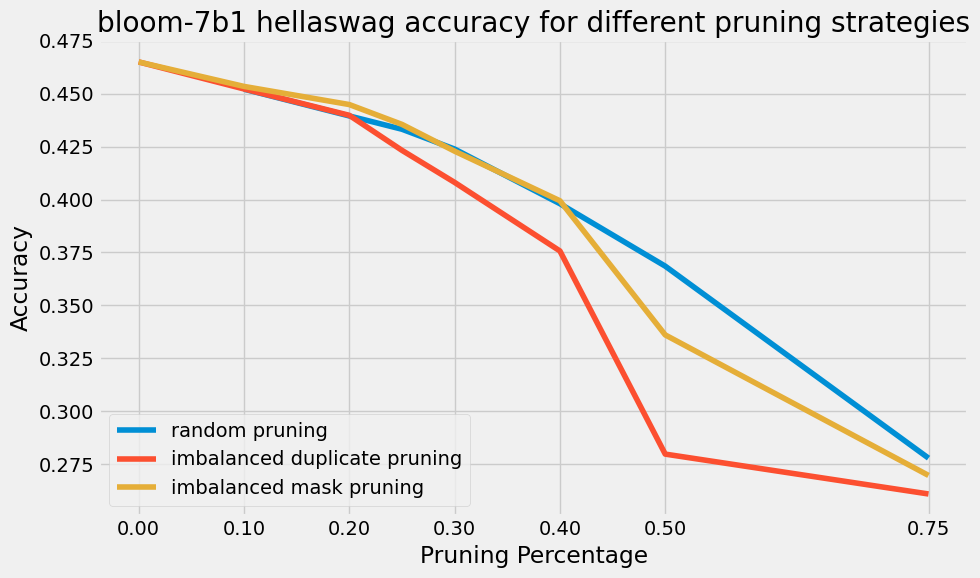

In [128]:
def plot_task_comparison(df, task, prune_metric, title, prune_methods = ['random_mask', 'imbalanced_correct', 'imbalanced_correct_mask', 'amazon'], model='opt-13b'):
    plt.figure(figsize=(10, 6))

    for prune_method in prune_methods:
        # Filtering data based on task, prune method, metric, and model
        task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                       ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
        mask = (task_data['prune_task'] == task) | (task_data['prune_task'] == 'random')
        task_data = task_data[mask]
        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Sort and plot each group
            sorted_data = group_data.sort_values(by=['percent'])
            plt.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{td[prune_method]}')

    # Setting plot details
    plt.title(f'{model} {task} {title}')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    plt.tight_layout()
    plt.show()

# Call the function for a specific task
plot_task_comparison(df_final, task='hellaswag', prune_metric='cosine_cosine', title = 'accuracy for different pruning strategies', prune_methods = ['random_mask', 'imbalanced_correct', 'imbalanced_correct_mask'], model='bloom-7b1')

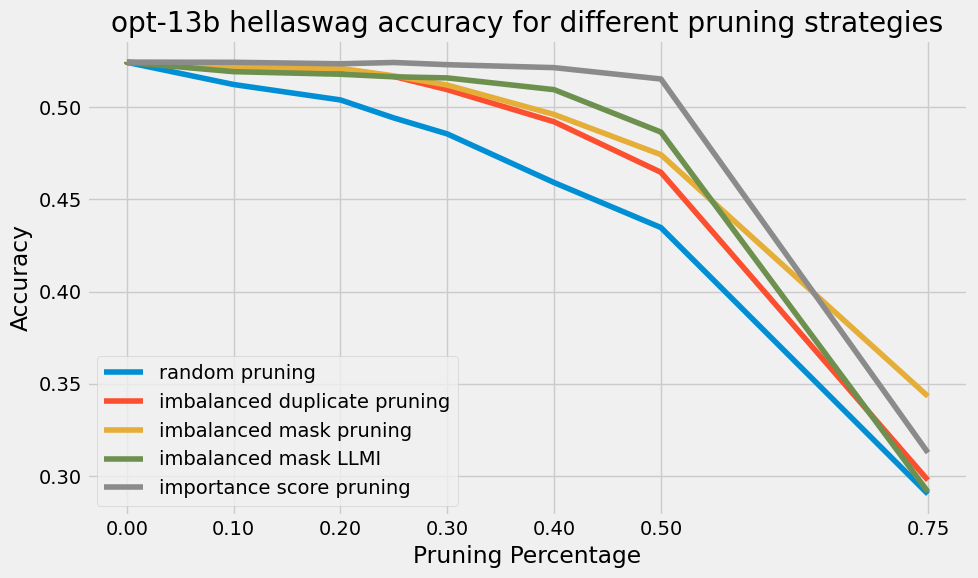

In [225]:
plot_task_comparison(df_final, task='hellaswag', title='accuracy for different pruning strategies', prune_metric='cosine_cosine', prune_methods = ['random_mask', 'imbalanced_correct', 'imbalanced_correct_mask', 'imbalanced_amazon', 'amazon'], model='opt-13b')

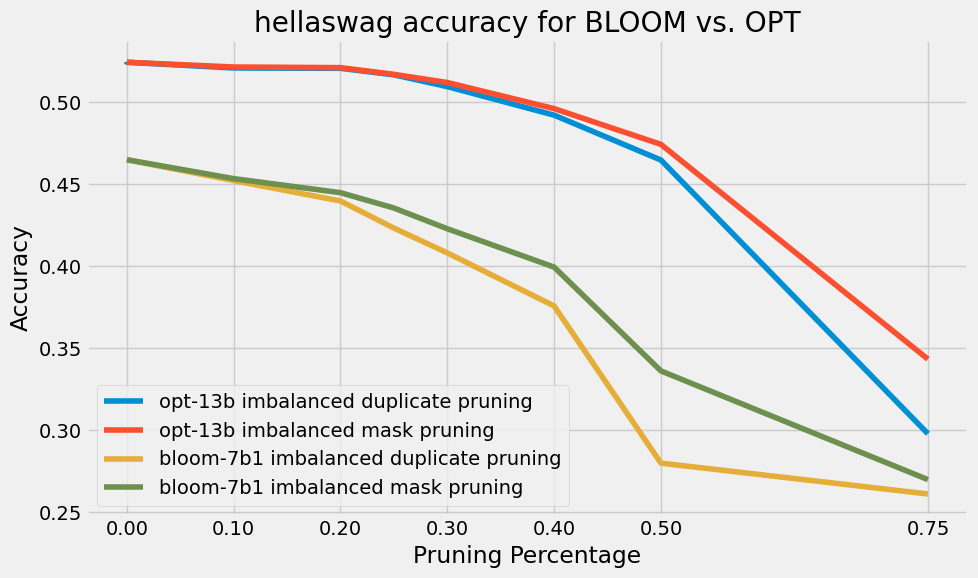

In [167]:
def bloom_vs_opt(df, task, prune_metric, title, prune_methods, model1='opt-13b', model2='bloom-7b1'):
    plt.figure(figsize=(10, 6))

    models = [model1, model2]
    for model in models:
        for prune_method in prune_methods:
            # Filtering data based on task, prune method, metric, and model
            task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                           ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
            mask = (task_data['prune_task'] == task) | (task_data['prune_task'] == 'random')
            task_data = task_data[mask]
            for prune_task, group_data in task_data.groupby(['prune_task']):
                # Sort and plot each group
                sorted_data = group_data.sort_values(by=['percent'])
                plt.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{model} {td[prune_method]}')

    # Setting plot details
    plt.title(f'{task} {title}')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    plt.tight_layout()
    plt.show()

# Call the function to compare two models for a specific task
bloom_vs_opt(df_final, task='hellaswag', prune_metric='cosine_cosine', title='accuracy for BLOOM vs. OPT', prune_methods=['imbalanced_correct', 'imbalanced_correct_mask'], model1='opt-13b', model2='bloom-7b1')


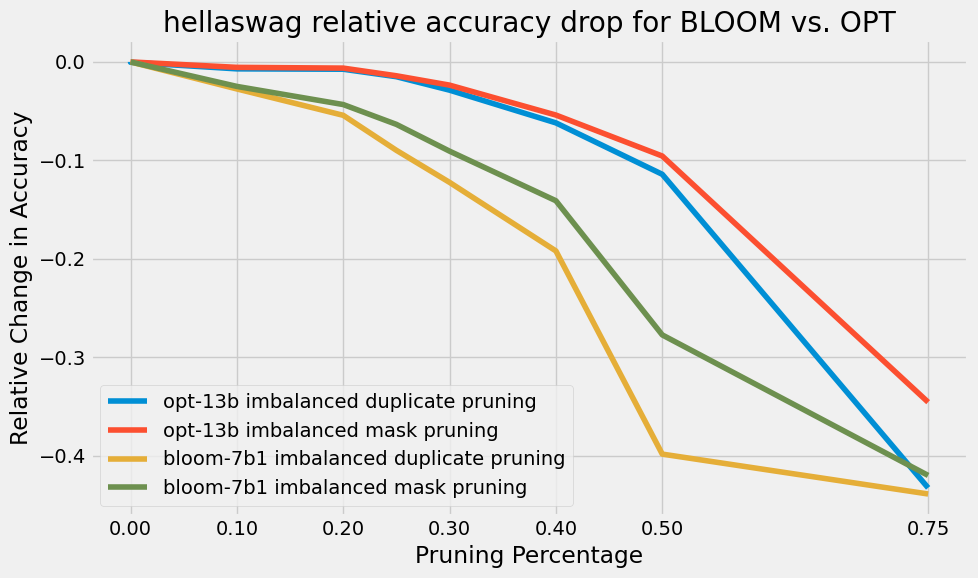

In [169]:
import matplotlib.pyplot as plt

def bloom_vs_opt(df, task, prune_metric, title, prune_methods, model1='opt-13b', model2='bloom-7b1'):
    plt.figure(figsize=(10, 6))

    models = [model1, model2]
    for model in models:
        for prune_method in prune_methods:
            # Filtering data based on task, prune method, metric, and model
            task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                           ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
            mask = (task_data['prune_task'] == task) | (task_data['prune_task'] == 'random')
            task_data = task_data[mask]
            for prune_task, group_data in task_data.groupby(['prune_task']):
                # Sort and plot each group
                sorted_data = group_data.sort_values(by=['percent'])
                
                # Calculate relative change in accuracy from the initial accuracy (percent = 0)
                initial_accuracy = sorted_data[sorted_data['percent'] == 0]['norm_accuracy'].values[0]
                sorted_data['relative_accuracy'] = (sorted_data['norm_accuracy'] - initial_accuracy) / initial_accuracy
                
                plt.plot(sorted_data['percent'], sorted_data['relative_accuracy'], label=f'{model} {td[prune_method]}')

    # Setting plot details
    plt.title(f'{task} {title}')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Relative Change in Accuracy')
    plt.legend(loc='lower left')
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    plt.tight_layout()
    plt.show()

# Call the function to compare two models for a specific task
bloom_vs_opt(df_final, task='hellaswag', prune_metric='cosine_cosine', title='relative accuracy drop for BLOOM vs. OPT', prune_methods=['imbalanced_correct', 'imbalanced_correct_mask'], model1='opt-13b', model2='bloom-7b1')


## Balanced vs. Imbalanced

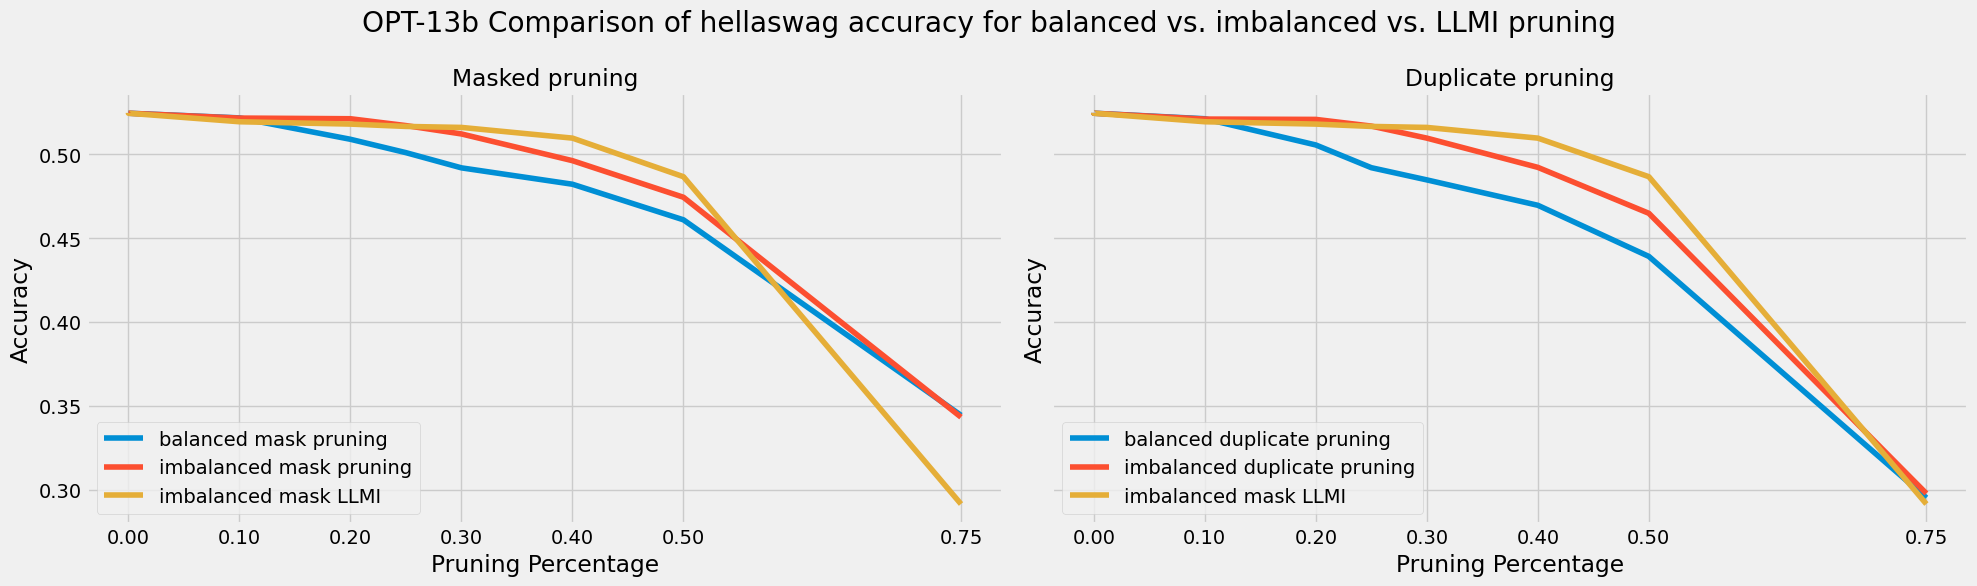

In [197]:
def plot_triple_comparison(df, task, prune_metric, title, subtitles, prune_methods = ['random_mask', 'imbalanced_correct', 'imbalanced_correct_mask', 'amazon'], model='opt-13b'):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    for ax, methods, sub_title in zip(axs, [prune_methods[:3], prune_methods[3:]], subtitles):
        for prune_method in methods:
            # Filtering data based on task, prune method, metric, and model
            task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                           ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
            mask = (task_data['prune_task'] == task) | (task_data['prune_task'] == 'random')
            task_data = task_data[mask]
            for prune_task, group_data in task_data.groupby(['prune_task']):
                # Sort and plot each group
                sorted_data = group_data.sort_values(by=['percent'])
                ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{td[prune_method]}')

        # Setting plot details
        ax.set_title(f'{sub_title}', fontsize='large')
        ax.set_xlabel('Pruning Percentage')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower left')
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])

    plt.suptitle(title, fontsize='x-large')
    plt.tight_layout()
    plt.show()

# Call the function to generate side-by-side plots
plot_triple_comparison(df_final, task='hellaswag', prune_metric='cosine_cosine', title='OPT-13b Comparison of hellaswag accuracy for balanced vs. imbalanced vs. LLMI pruning', subtitles= ['Masked pruning', 'Duplicate pruning'], prune_methods=['balanced_mask', 'imbalanced_correct_mask', 'imbalanced_amazon', 'balanced', 'imbalanced_correct', 'imbalanced_amazon'], model='opt-13b')

## Duplicate vs. Masked pruning

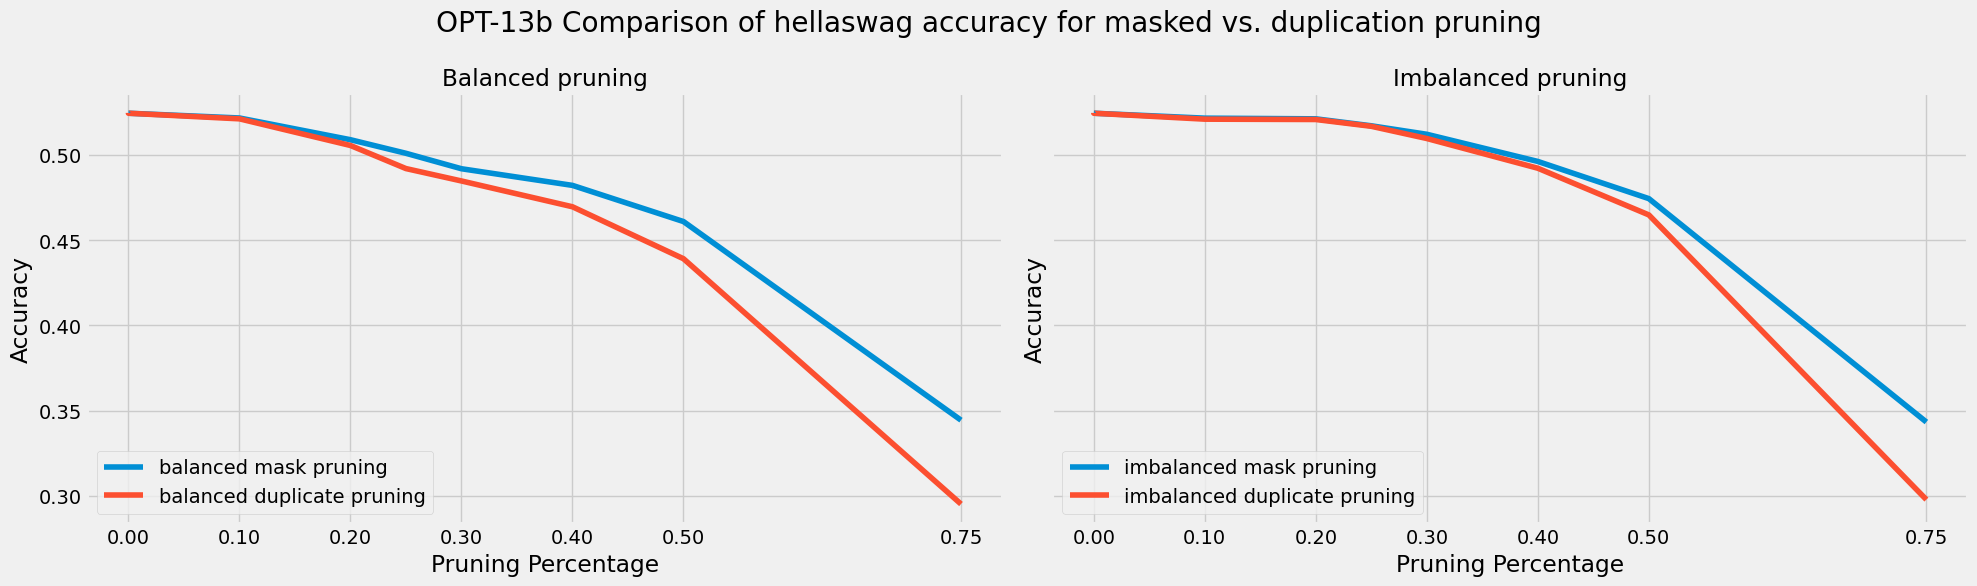

In [199]:
def plot_double_comparison(df, task, prune_metric, title, subtitles, prune_methods = ['random_mask', 'imbalanced_correct', 'imbalanced_correct_mask', 'amazon'], model='opt-13b'):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    for ax, methods, sub_title in zip(axs, [prune_methods[:2], prune_methods[2:]], subtitles):
        for prune_method in methods:
            # Filtering data based on task, prune method, metric, and model
            task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                           ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
            mask = (task_data['prune_task'] == task) | (task_data['prune_task'] == 'random')
            task_data = task_data[mask]
            for prune_task, group_data in task_data.groupby(['prune_task']):
                # Sort and plot each group
                sorted_data = group_data.sort_values(by=['percent'])
                ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{td[prune_method]}')

        # Setting plot details
        ax.set_title(f'{sub_title}', fontsize='large')
        ax.set_xlabel('Pruning Percentage')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower left')
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])

    plt.suptitle(title, fontsize='x-large')
    plt.tight_layout()
    plt.show()

# Call the function to generate side-by-side plots

plot_double_comparison(df_final, task='hellaswag', prune_metric='cosine_cosine', title='OPT-13b Comparison of hellaswag accuracy for masked vs. duplication pruning', subtitles= ['Balanced pruning', 'Imbalanced pruning'], prune_methods=['balanced_mask', 'balanced', 'imbalanced_correct_mask', 'imbalanced_correct'], model='opt-13b')

## OPT-13b pruned on hellaswag with our method vs. amazon vs. random, average accuracy across tasks

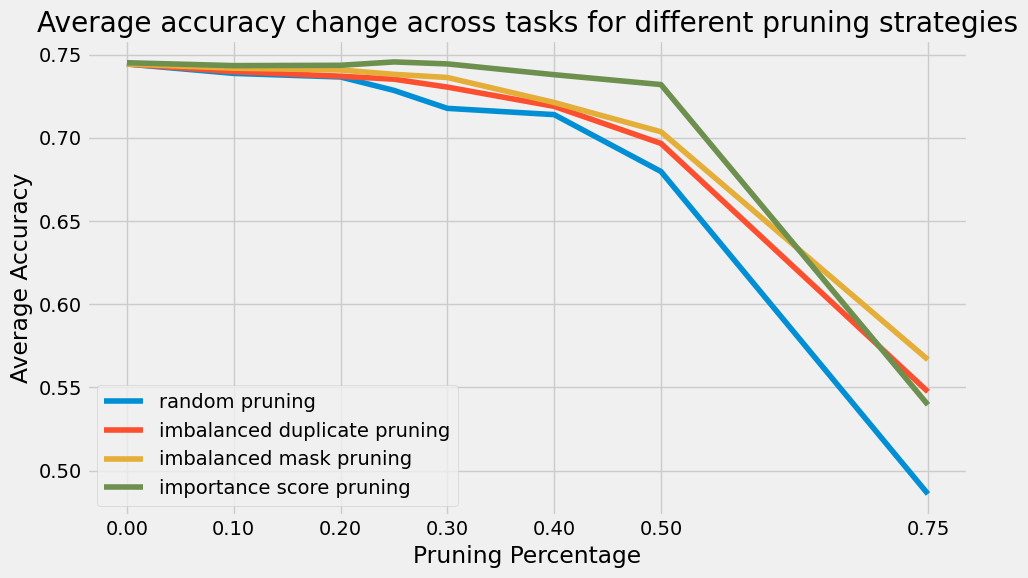

In [206]:
def plot_average_task_comparison(df, tasks, prune_metric, prune_methods= ['random_mask', 'imbalanced_correct', 'imbalanced_correct_mask', 'amazon'], model='opt-13b'):
    plt.figure(figsize=(10, 6))

    for prune_method in prune_methods:
        task_data = df[(df['task'].isin(tasks)) & (df['prune_method'] == prune_method) & 
                       ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
        
        mask = (task_data['prune_task'] == 'hellaswag') | (task_data['prune_task'] == 'random')
        task_data = task_data[mask]

        # Group by pruning percentage and calculate average accuracy
        average_data = task_data.groupby('percent')['norm_accuracy'].mean().reset_index()
        
        # Sort and plot the average data
        sorted_data = average_data.sort_values(by=['percent'])
        plt.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{td[prune_method]}')

    # Setting plot details
    plt.title(f'Average accuracy change across tasks for different pruning strategies')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Average Accuracy')
    plt.legend(loc='lower left')
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    plt.tight_layout()
    plt.show()

# Call the function for specific tasks
tasks = ['hellaswag', 'blimp_ellipsis_n_bar_1', 'blimp_irregular_plural_subject_verb_agreement_1', 'arc_easy']
plot_average_task_comparison(df_final, tasks=tasks, prune_metric='cosine_cosine', model='opt-13b')

## Euclidean vs cosine


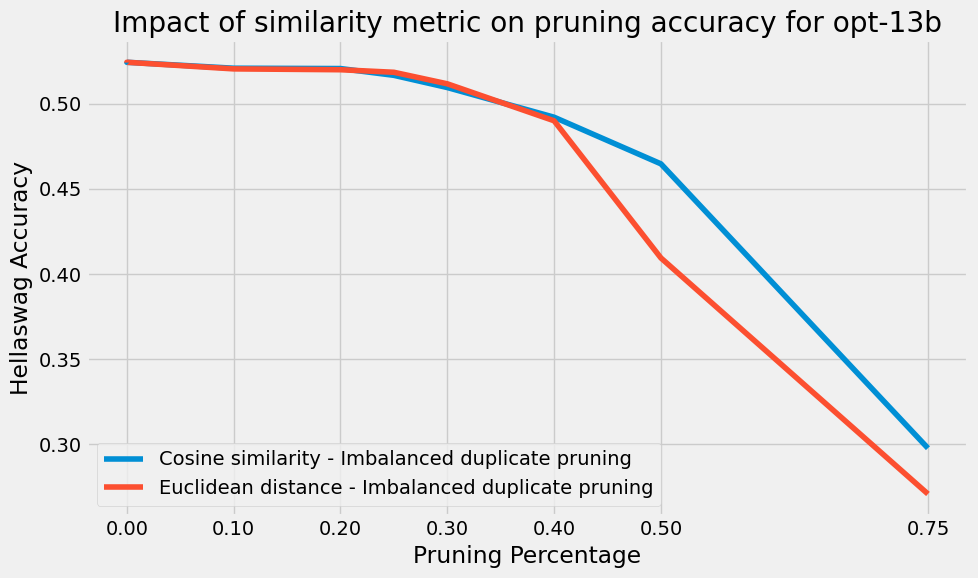

In [188]:
translate = {'cosine_cosine': 'Cosine similarity - Imbalanced duplicate pruning', 'euclidean_euclidean': 'Euclidean distance - Imbalanced duplicate pruning'}
def plot_metric_comparison(df, task, prune_method, prune_metrics = ['r_mask', 'balanced_mask', 'imbalanced_correct_mask', 'imbalanced_correct', 'amazon'], model='opt-13b'):
    plt.figure(figsize=(10, 6))

    for prune_metric in prune_metrics:
        # Filtering data based on task, prune method, metric, and model
        task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                       ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
        mask = (task_data['prune_task'] == task) | (task_data['prune_task'] == 'random')
        task_data = task_data[mask]
        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Sort and plot each group
            sorted_data = group_data.sort_values(by=['percent'])
            plt.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{translate[prune_metric]}')

    # Setting plot details
    plt.title(f'Impact of similarity metric on pruning accuracy for {model}')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Hellaswag Accuracy')
    plt.legend(loc='lower left')
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    plt.tight_layout()
    plt.show()

# Call the function for a specific task
plot_metric_comparison(df_final, task='hellaswag', prune_method='imbalanced_correct', prune_metrics = ['cosine_cosine', 'euclidean_euclidean'])

## Clustering metric - Cosine vs random

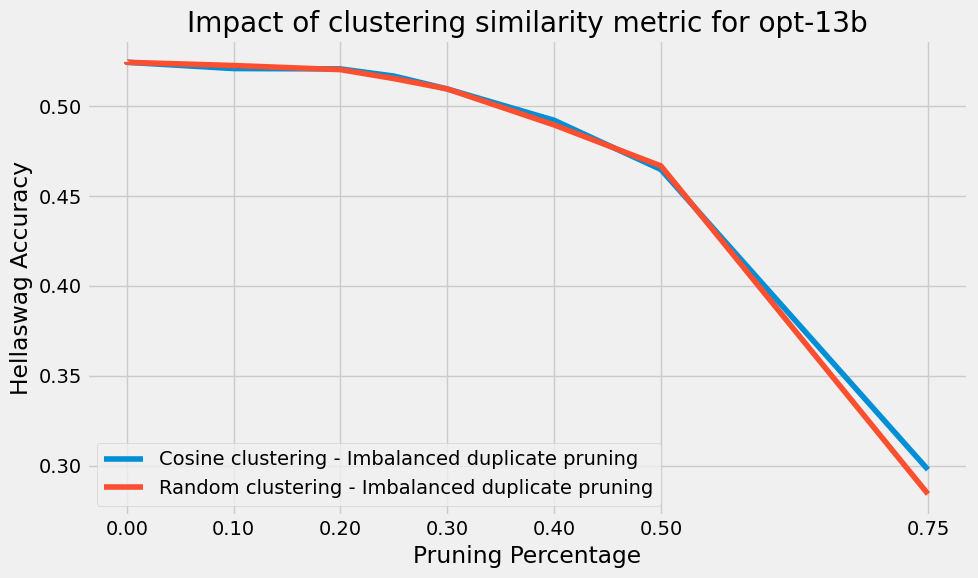

In [189]:
adjust = {'cosine_cosine': 'Cosine clustering - Imbalanced duplicate pruning', 'cosine_random': 'Random clustering - Imbalanced duplicate pruning'}

def plot_metric_clustering(df, task, prune_method, prune_metrics = ['r_mask', 'balanced_mask', 'imbalanced_correct_mask', 'imbalanced_correct', 'amazon'], model='opt-13b'):
    plt.figure(figsize=(10, 6))

    for prune_metric in prune_metrics:
        # Filtering data based on task, prune method, metric, and model
        task_data = df[(df['task'] == task) & (df['prune_method'] == prune_method) & 
                       ((df['metric'] == prune_metric) | (df['metric'] == 'amazon') | (df['metric'] == 'random_random')) & (df['model'] == model)]
        mask = (task_data['prune_task'] == task) | (task_data['prune_task'] == 'random')
        task_data = task_data[mask]
        for prune_task, group_data in task_data.groupby(['prune_task']):
            # Sort and plot each group
            sorted_data = group_data.sort_values(by=['percent'])
            plt.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{adjust[prune_metric]}')

    # Setting plot details
    plt.title(f'Impact of clustering similarity metric for {model}')
    plt.xlabel('Pruning Percentage')
    plt.ylabel('Hellaswag Accuracy')
    plt.legend(loc='lower left')
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    plt.tight_layout()
    plt.show()

# Call the function for a specific task
plot_metric_clustering(df_final, task='hellaswag', prune_method='imbalanced_correct', prune_metrics = ['cosine_cosine', 'cosine_random'])

## Prune on different tasks

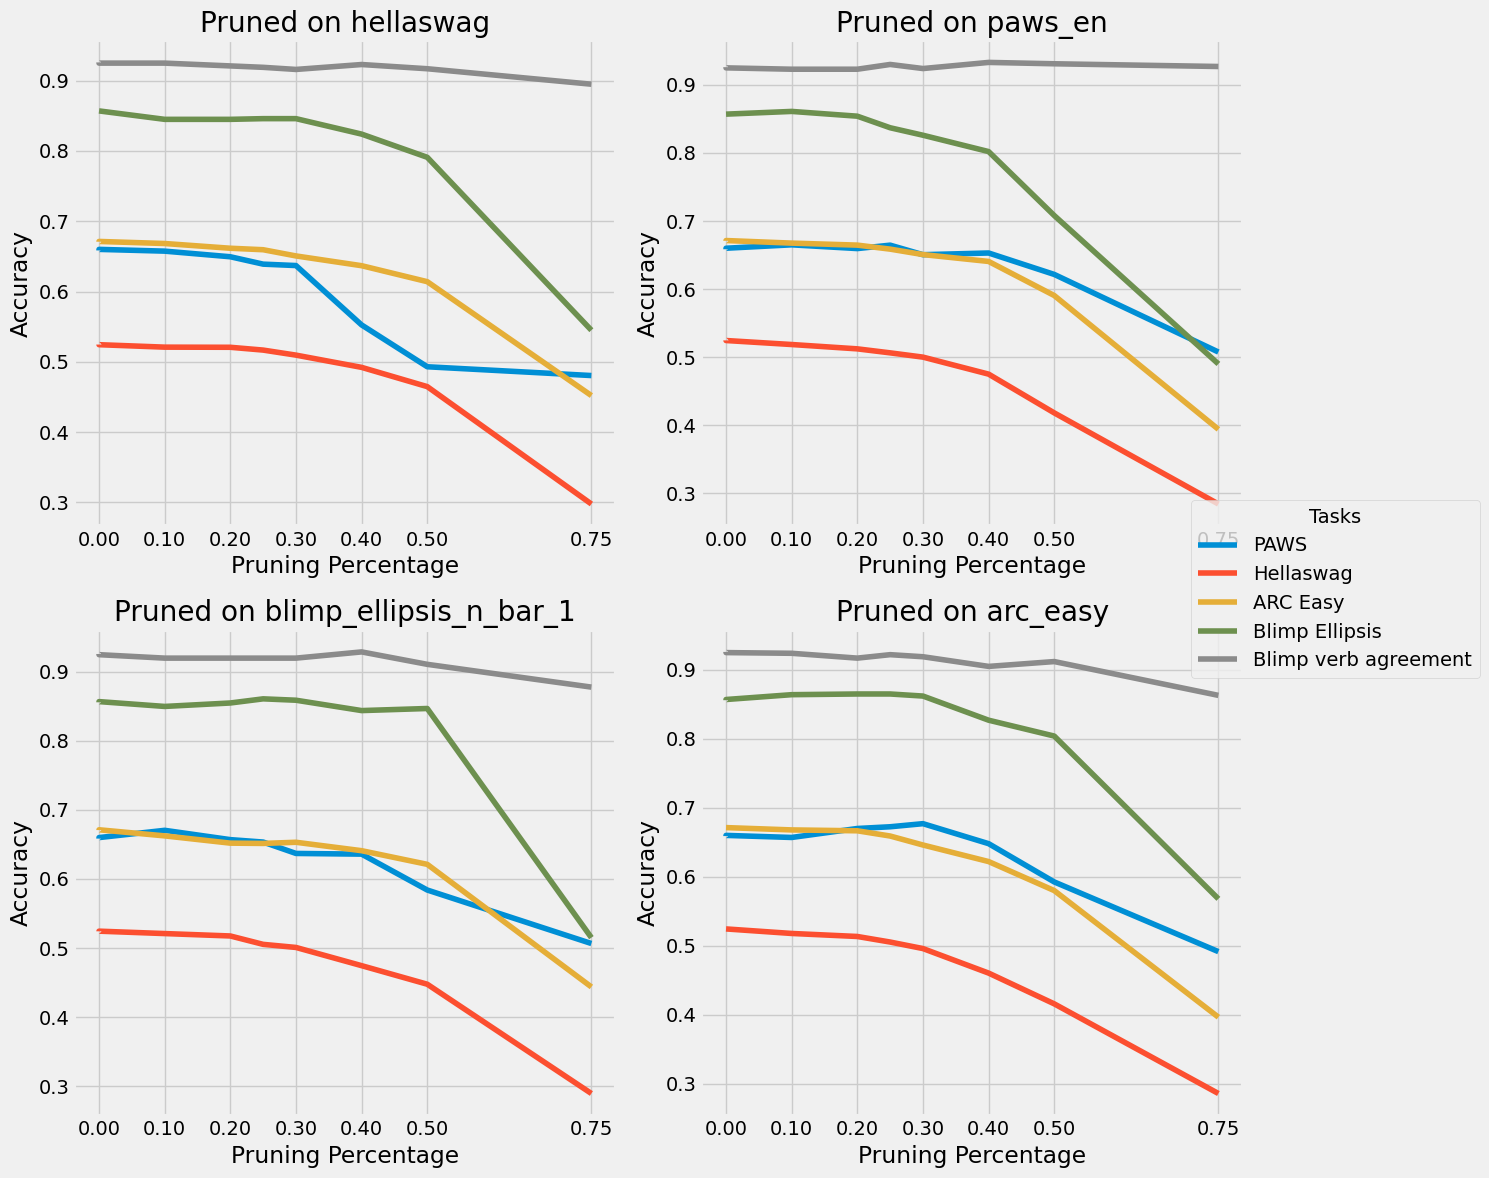

In [202]:
translator = {'arc_easy': 'ARC Easy',
            'hellaswag': 'Hellaswag', 
            'paws_en': 'PAWS', 
            'blimp_ellipsis_n_bar_1': 'Blimp Ellipsis', 
            'blimp_irregular_plural_subject_verb_agreement_1': 'Blimp verb agreement'}

def plot_comparison_for_prune_tasks(df, prune_method, prune_metric, prune_tasks, title, model='opt-13b'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    lines = []
    labels = []
    
    for i, prune_task in enumerate(prune_tasks):
        ax = axes[i]
        
        # Filter data based on prune method, metric, prune task, and model
        filtered_data = df[(df['prune_method'] == prune_method) & 
                           (df['metric'] == prune_metric) & 
                           (df['prune_task'] == prune_task) & 
                           (df['model'] == model)]
        
        tasks = filtered_data['task'].unique()
        
        for task in tasks:
            task_data = filtered_data[filtered_data['task'] == task]
            # Sort and plot each task
            sorted_data = task_data.sort_values(by=['percent'])
            line, = ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{translator[task]}')
            if i == 0:  # Collecting lines and labels for the first plot for the common legend
                lines.append(line)
                labels.append(translator[task])
        
        # Setting plot details
        ax.set_title(f'Pruned on {prune_task}')
        ax.set_xlabel('Pruning Percentage')
        ax.set_ylabel('Accuracy')
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    
    # Creating a single legend for the entire figure
    fig.legend(lines, labels, loc='center right', title='Tasks')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

prune_tasks = ['hellaswag', 'paws_en', 'blimp_ellipsis_n_bar_1', 'arc_easy']
plot_comparison_for_prune_tasks(df_final, prune_method='imbalanced_correct', prune_metric='cosine_cosine', prune_tasks=prune_tasks, title='accuracy')


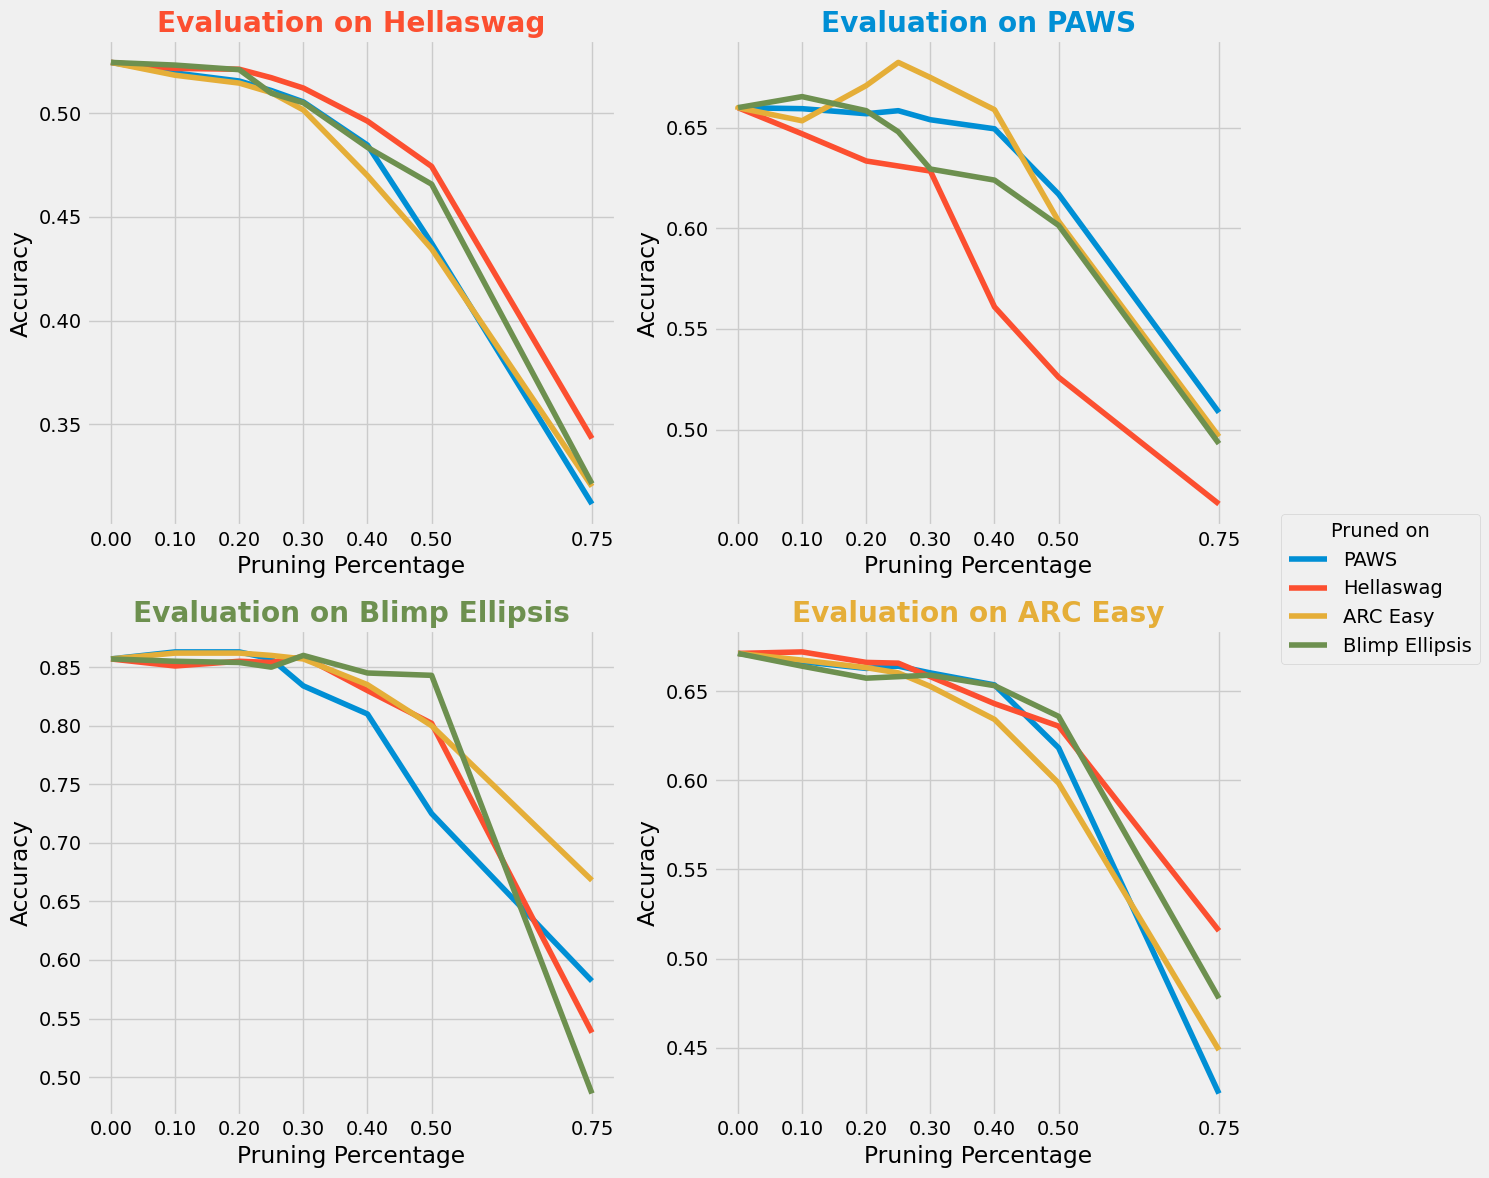

In [224]:
def plot_comparison_for_eval_tasks(df, prune_method, prune_metric, eval_tasks, title, model='opt-13b'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    lines = []
    labels = []
    color_map = {}
    
    for i, eval_task in enumerate(eval_tasks):
        ax = axes[i]
        
        # Filter data based on prune method, metric, evaluation task, and model
        filtered_data = df[(df['prune_method'] == prune_method) & 
                           (df['metric'] == prune_metric) & 
                           (df['model'] == model)]
        
        prune_tasks = filtered_data['prune_task'].unique()
        
        for prune_task in prune_tasks:
            task_data = filtered_data[(filtered_data['task'] == eval_task) & 
                                      (filtered_data['prune_task'] == prune_task)]
            # Sort and plot each prune task
            sorted_data = task_data.sort_values(by=['percent'])
            line, = ax.plot(sorted_data['percent'], sorted_data['norm_accuracy'], label=f'{translator[prune_task]}')
            if prune_task not in color_map:
                color_map[prune_task] = line.get_color()            
            if i == 0:  # Collecting lines and labels for the first plot for the common legend
                lines.append(line)
                labels.append(translator[prune_task])
        
        # Setting plot details
        ax.set_title(f'Evaluation on {translator[eval_task]}', color=color_map[eval_task], fontweight='bold')
        ax.set_xlabel('Pruning Percentage')
        ax.set_ylabel('Accuracy')
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    
    # Creating a single legend for the entire figure
    fig.legend(lines, labels, loc='center right', title='Pruned on')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

eval_tasks = ['hellaswag', 'paws_en', 'blimp_ellipsis_n_bar_1', 'arc_easy']
plot_comparison_for_eval_tasks(df_final, prune_method='imbalanced_correct_mask', prune_metric='cosine_cosine', eval_tasks=eval_tasks, title='accuracy')


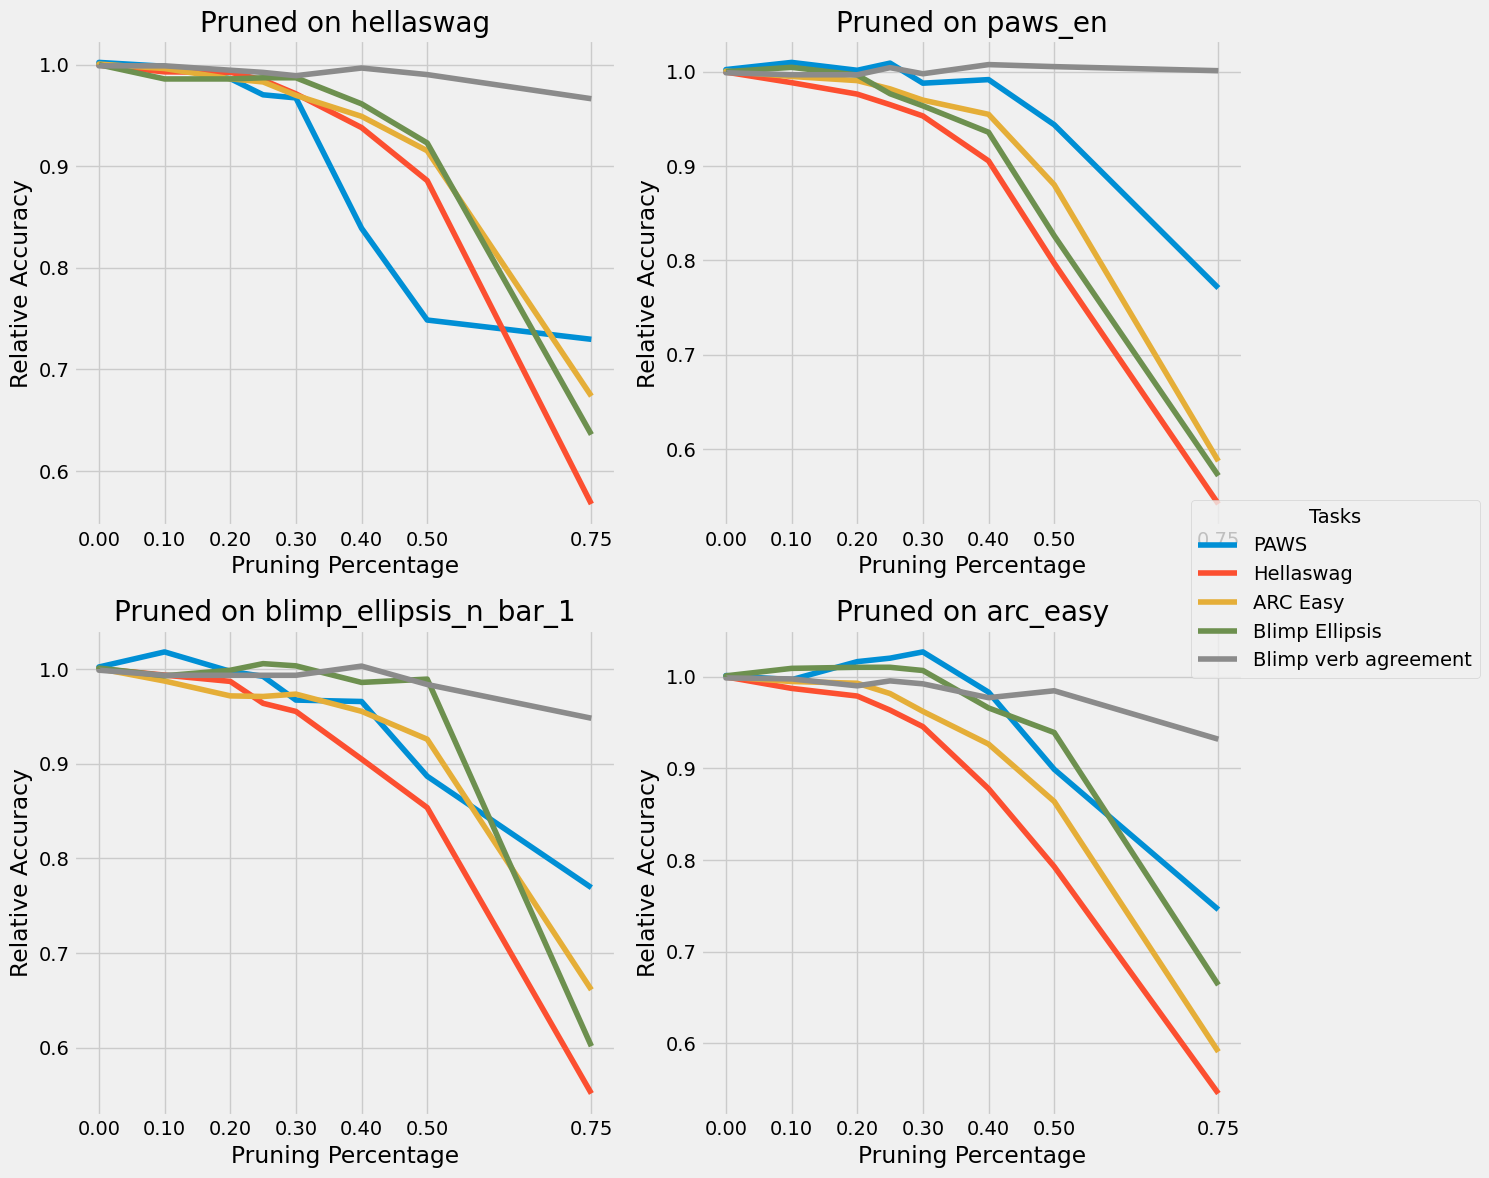

In [203]:
def plot_comparison_for_prune_tasks(df, prune_method, prune_metric, prune_tasks, title, model='opt-13b'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    lines = []
    labels = []
    
    for i, prune_task in enumerate(prune_tasks):
        ax = axes[i]
        
        # Filter data based on prune method, metric, prune task, and model
        filtered_data = df[(df['prune_method'] == prune_method) & 
                           (df['metric'] == prune_metric) & 
                           (df['prune_task'] == prune_task) & 
                           (df['model'] == model)]
        
        tasks = filtered_data['task'].unique()
        
        for task in tasks:
            task_data = filtered_data[filtered_data['task'] == task]
            # Sort data by pruning percentage
            sorted_data = task_data.sort_values(by=['percent'])
            
            # Get baseline accuracy (0% pruning)
            baseline_accuracy = sorted_data[sorted_data['percent'] == 0]['norm_accuracy'].values[0]
            
            # Calculate relative accuracy
            sorted_data['relative_accuracy'] = sorted_data['norm_accuracy'] / baseline_accuracy
            
            line, = ax.plot(sorted_data['percent'], sorted_data['relative_accuracy'], label=f'{translator[task]}')
            if i == 0:  # Collecting lines and labels for the first plot for the common legend
                lines.append(line)
                labels.append(translator[task])
        
        # Setting plot details
        ax.set_title(f'Pruned on {prune_task}')
        ax.set_xlabel('Pruning Percentage')
        ax.set_ylabel('Relative Accuracy')
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75])
    
    # Creating a single legend for the entire figure
    fig.legend(lines, labels, loc='center right', title='Tasks')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

prune_tasks = ['hellaswag', 'paws_en', 'blimp_ellipsis_n_bar_1', 'arc_easy']
plot_comparison_for_prune_tasks(df_final, prune_method='imbalanced_correct', prune_metric='cosine_cosine', prune_tasks=prune_tasks, title='Relative Accuracy to 0% Pruning')
